# Zillow Prize: Zillow’s Home Value Prediction

### Competition Description
n this competition, Zillow is asking you to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. The log error is defined as

**logerror = log(Zestimate) - log(Saleprice)**

and it is recorded in the transactions file train.csv. In this competition, you are going to predict the logerror for the months in Fall 2017. Since all the real estate transactions in the U.S. are publicly available, we will close the competition  before the evaluation period begins.

### Additional Information
**Zillow:**

Zillow is an online real estate database company founded in 2006 - Wikipedia

**Zestimate:**

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property.

### Objective:

Building a model to improve the Zestimate residual error.


# Load and Explore Data

In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, PolynomialFeatures, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import os
import time

import warnings
warnings.filterwarnings("ignore")

def MAE(y, ypred):
    
    import numpy as np
    
    return np.sum([abs(y[i]-ypred[i]) for i in range(len(y))]) / len(y)  

C:\Users\johnl\Anaconda\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\johnl\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\johnl\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you 

### Read in dataframe

In [2]:
train_df = pd.read_csv(r"C:\Users\johnl\Documents\zillow-prize\train_2016_v2.csv", parse_dates=["transactiondate"])
train_df.shape

(90275, 3)

In [3]:
train_df.logerror.describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

## Target Exploration

Our target is logerror we will examine it here

In [4]:
from scipy import stats

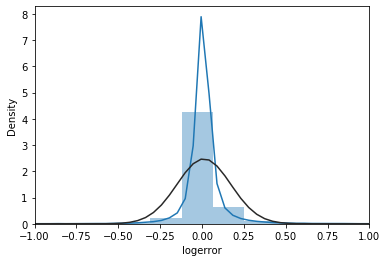

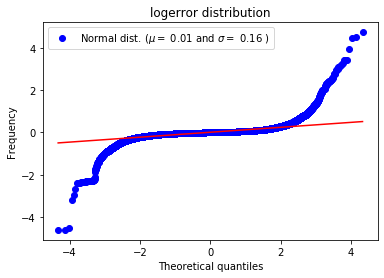

In [5]:
def target_distribution():
    (mu, sigma) =stats.norm.fit(train_df['logerror'])
    ax = sns.distplot(train_df['logerror'], fit = stats.norm)
    ax.set_xlim(-1,1)
    fig = plt.figure()
    res = stats.probplot(train_df['logerror'], plot=plt)

    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('logerror distribution')
target_distribution()

From the plot above and also the description function we can see we have several outliers that need to be removed for example the clear points at +/- 4 should definitely be removed. We will also examine measures of normality 

In [6]:
print("Skewness: " + str(train_df['logerror'].skew()))
print("Kurtosis: " + str(train_df['logerror'].kurt()))

Skewness: 2.1688282902579354
Kurtosis: 131.37539356934877


#### What do these values mean?
##### Rules of Thumb for Skewness
1. If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
2. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed
3. If the skewness is less than -1 or greater than 1, the data are highly skewed

As our value is 2.16 we see the data has a high positive skew

##### What is Kurtosis?
- The kurtosis parameter is a measure of the combined weight of the tails relative to the rest of the distribution.
- Kurtosis is all about the tails of the distribution – not the peakedness or flatness.  It measures the tail-heaviness of the distribution.

Kurtosis is usually measured against the normal distribution.  
- If the kurtosis is close to 0, then a normal distribution is often assumed.  These are called mesokurtic distributions.
- If the kurtosis is less than zero, then the distribution is light tails and is called a platykurtic distribution.  
- If the kurtosis is greater than zero, then the distribution has heavier tails and is called a leptokurtic distribution

The values for asymmetry and kurtosis between -2 and +2 are considered acceptable in order to prove normal univariate distribution (George & Mallery, 2010). George, D., & Mallery, M. (2010). 

#### Identifcation of Outliers
I will be using the 1.5 IQR rule for my classification of outliers <br>
The method for the 1.5 interquartile range (IQR) rule is as follows:
1. Calculate the interquartile range for the data.
2. Multiply the interquartile range (IQR) by 1.5 (a constant used to discern outliers).
3. Add 1.5 x (IQR) to the third quartile. Any number greater than this is a suspected outlier.
4. Subtract 1.5 x (IQR) from the first quartile. Any number less than this is a suspected outlier.

However due to a high percentage of our data falling outside this range >10% im going to experiment with expanding the range by using 2.5 instead of 1.5

In [7]:
Q1 = train_df['logerror'].quantile(.25)
Q3 = train_df['logerror'].quantile(.75)
IRQ = Q3 - Q1
IRQ_rule = 2.5 * IRQ
print(IRQ_rule)
print(Q3+ IRQ_rule)
outliers = train_df[(train_df['logerror']< (Q1 - IRQ_rule)) | (train_df['logerror'] > (Q3 + IRQ_rule))]
print(len(outliers))
outlier_percent = (len(outliers)/len(train_df))*100
print(outlier_percent)

0.16125
0.20045000000000002
6042
6.692882857934091


In [8]:
#removing outliers
cond =train_df['logerror'].isin(outliers['logerror'])
train_df.drop(train_df[cond].index, inplace = True)

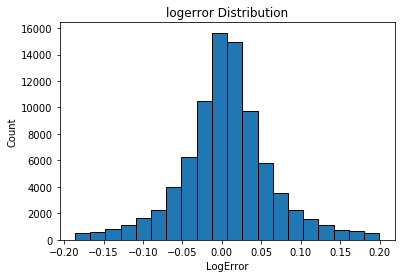

In [9]:
# Histogram Plot of Site EUI

plt.hist(train_df['logerror'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('LogError'); 
plt.ylabel('Count'); plt.title('logerror Distribution');

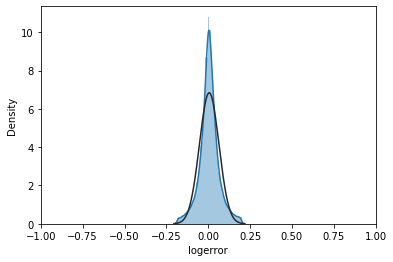

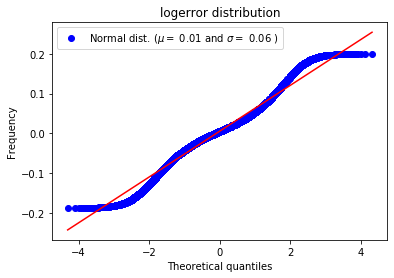

In [10]:
target_distribution()

# Exploratory Data Analysis

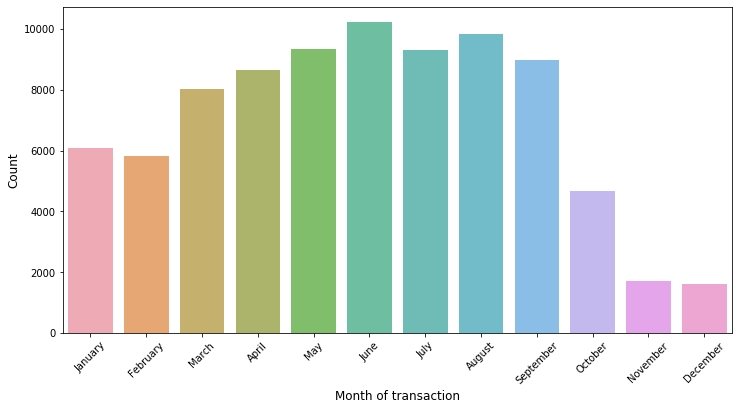

In [11]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month


plt.figure(figsize=(12,6))
ax = sns.countplot(x =train_df['transaction_month'], alpha=0.8 )
plt.xticks(rotation=45)
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Count', fontsize=12)
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.show()

**Note:**

From the data page as well The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016. So we have shorter bars in the last three months.

## Properties File 

In [12]:
property_df= pd.read_csv(r"C:\Users\johnl\Documents\zillow-prize\properties_2016.csv")
property_df.shape

(2985217, 58)

In [13]:
property_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [14]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
missing_values_table(property_df)

Your selected dataframe has 58 columns.
There are 57 columns that have missing values.


,Missing Values,% of Total Values
storytypeid,2983593,99.9
basementsqft,2983589,99.9
yardbuildingsqft26,2982570,99.9
fireplaceflag,2980054,99.8
architecturalstyletypeid,2979156,99.8
typeconstructiontypeid,2978470,99.8
finishedsquarefeet13,2977545,99.7
buildingclasstypeid,2972588,99.6
decktypeid,2968121,99.4
finishedsquarefeet6,2963216,99.3


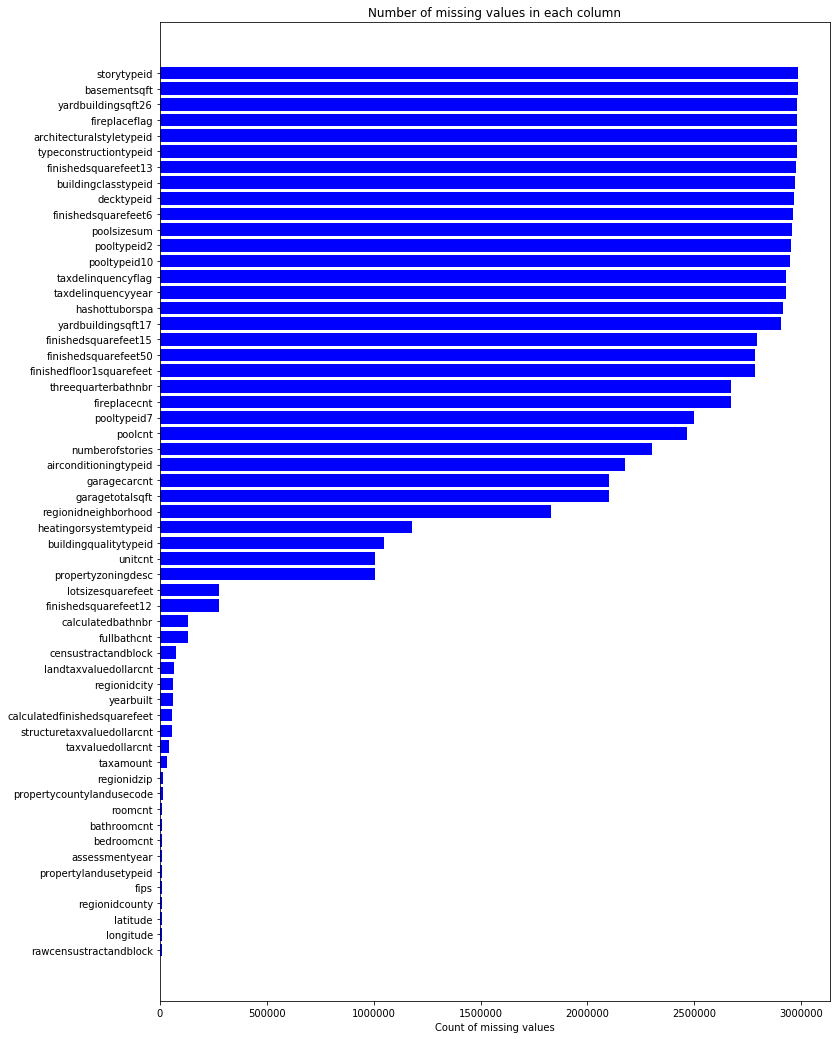

In [15]:
def missing_visual(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df.loc[missing_df['missing_count']>0]
    missing_df = missing_df.sort_values(by='missing_count')

    ind = np.arange(missing_df.shape[0])
    width = 0.9
    fig, ax = plt.subplots(figsize=(12,18))
    rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
    ax.set_yticks(ind)
    ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
    ax.set_xlabel("Count of missing values")
    ax.set_title("Number of missing values in each column")
    plt.show()
missing_visual(property_df)

In [16]:
train_df = pd.merge(train_df, property_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


## Univariate Analysis

### Corelation Matrix

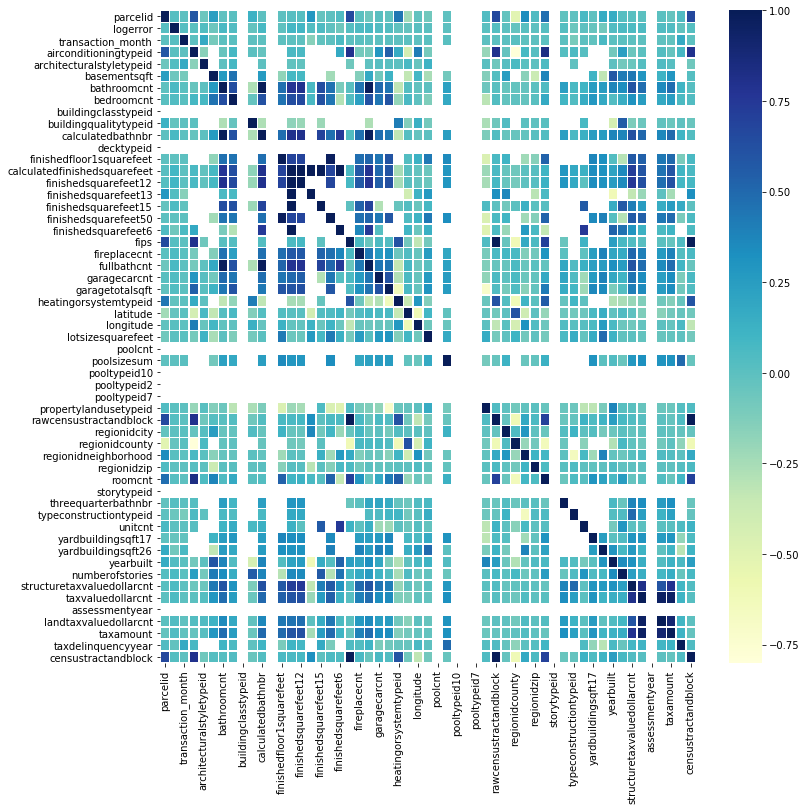

In [17]:
corrmat = train_df.corr()
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat,
                 annot=False,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()

The correlation of the target variable with the given set of variables are low overall.

There are few variables without any correlation values, they are probably a single value feature

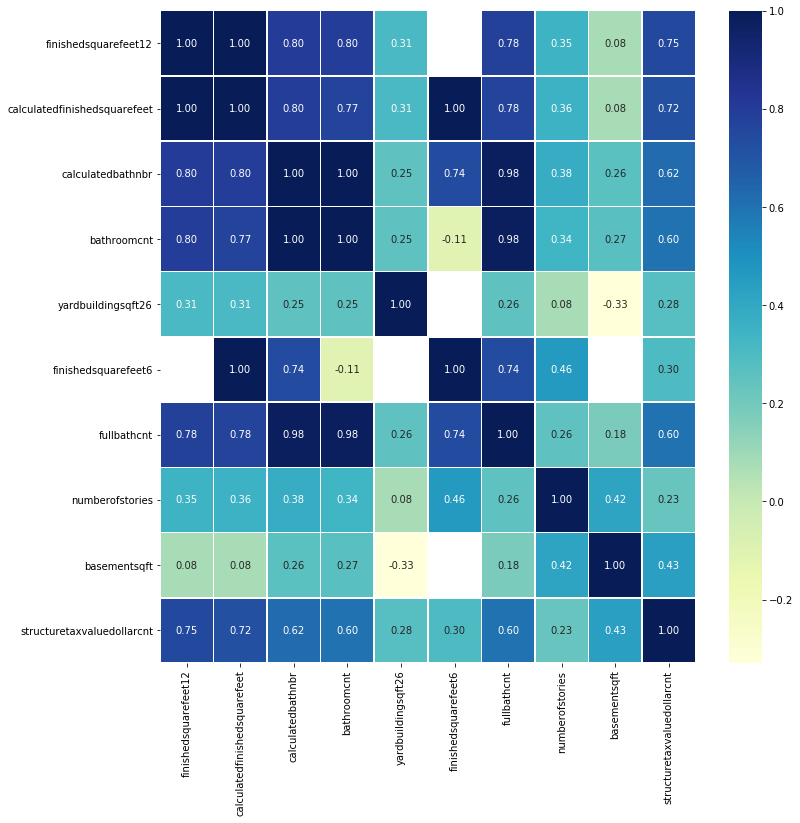

In [18]:
def correlation_list(df, target):
    x = df[df.columns[1:]].corr()[target][:]
    return x.sort_values(ascending = False)
    
#correlation_list(train_df, "logerror")

def correlation_importance(df,target, num_features):
    x = df[df.columns[1:]].corr()[target][:]
    x = x.sort_values(key = abs, ascending = False)
    x = x[1:num_features+1]
    
    
    
    return x
def important_features(df,target, num_features):
    x = correlation_importance(df,target, num_features)
    index = x.index
    cols_to_use= list(index)
    return cols_to_use

important_features(train_df, "logerror",10)
#correlation_importance(train_df, "logerror",10)
def important_matrix(df,target, num_features):
    x = correlation_importance(df,target, num_features)
    index = x.index
    cols_to_use= list(index)

    temp_df = train_df[cols_to_use]
    corrmat = temp_df.corr()
    fig, ax = plt.subplots(figsize=(12, 12))

    sns.heatmap(corrmat,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
    bottom, top = ax.get_ylim()
important_matrix(train_df, "logerror",10)

### Multicollinearity

[Text(0, 0.5, 'Features'),
 Text(0.5, 0, 'VIF Scores'),
 Text(0.5, 1.0, 'Variables Which Exhibit Multicollinearity')]

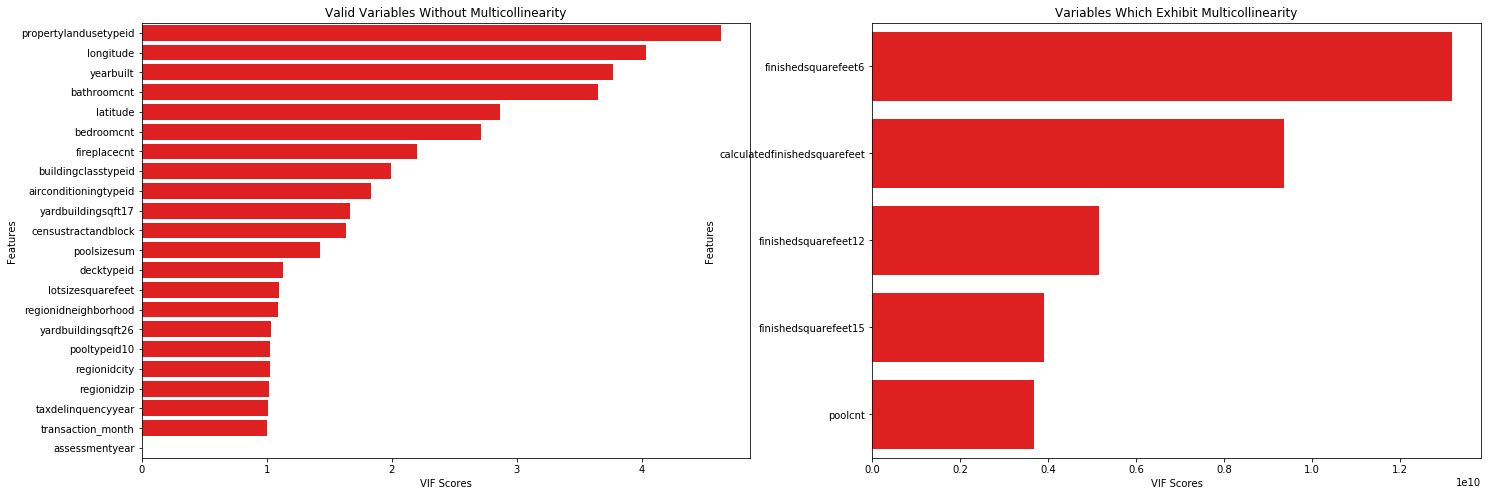

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
import warnings
warnings.filterwarnings("ignore")

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif


numericalCol = []
for f in train_df.columns:
    #print (f)
    if train_df[f].dtype!='object' and f not in ["parcelid", "transactiondate", "logerror"]:
        numericalCol.append(f)
mergedFilterd = train_df[numericalCol].fillna(-999)
vifDict = calculate_vif_(mergedFilterd)

vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(24,8)
sns.barplot(data=validVariables,x="vifScore",y="variables",ax=ax1,orient="h",color="red")
sns.barplot(data=variablesWithMC.head(5),x="vifScore",y="variables",ax=ax2,orient="h",color="red")
ax1.set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity")

[Text(0, 0.5, 'No Of Occurences'),
 Text(0.5, 0, 'Month Of The Year'),
 Text(0.5, 1.0, 'No Of Occurunces Across Month In 2016'),
 None]

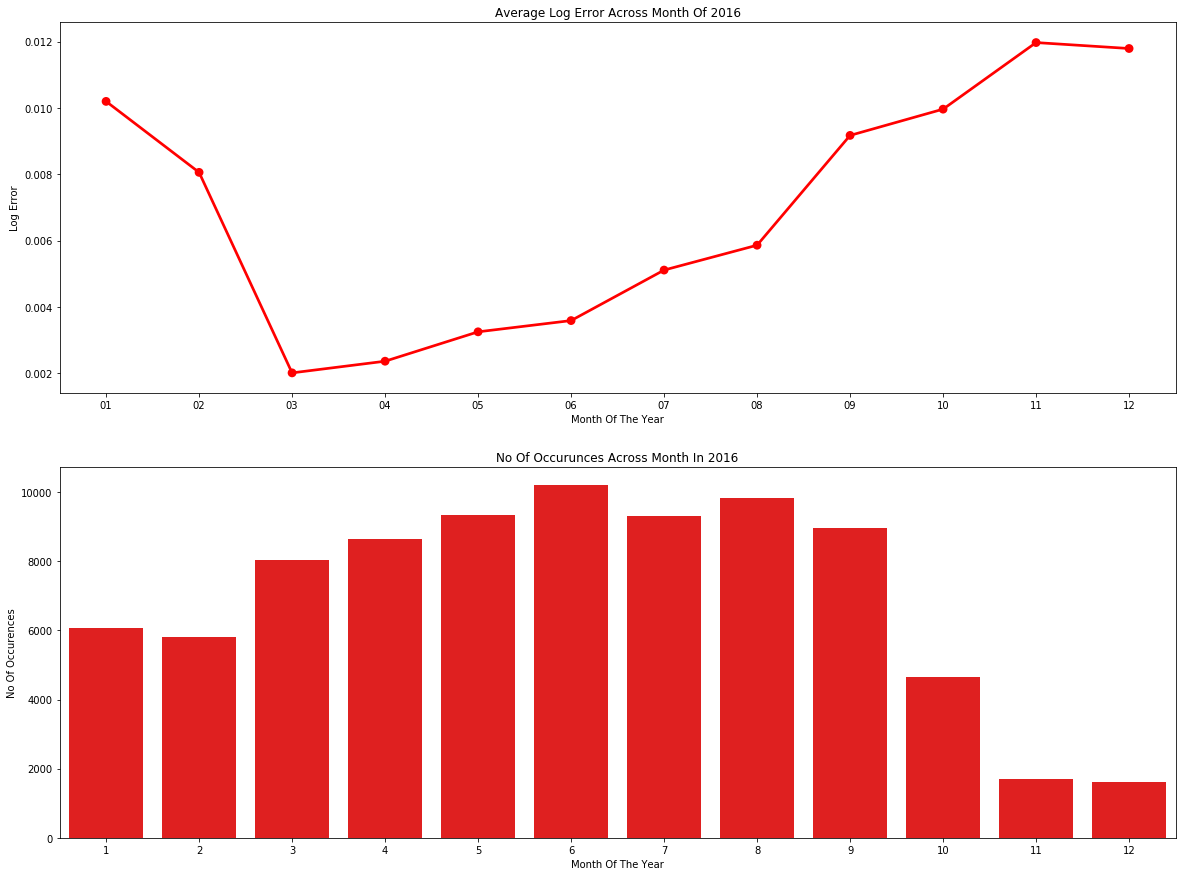

In [20]:
train_df["year"] = train_df.transactiondate.map(lambda x: str(x).split("-")[0])
train_df["month"] = train_df.transactiondate.map(lambda x: str(x).split("-")[1])
train_df["day"] = train_df.transactiondate.map(lambda x: str(x).split("-")[2].split()[0])

traingroupedMonth = train_df.groupby(["month"])["logerror"].mean().to_frame().reset_index()
traingroupedDay = train_df.groupby(["day"])["logerror"].mean().to_frame().reset_index()
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,15)


sns.pointplot(x=traingroupedMonth["month"], y=traingroupedMonth["logerror"], data=traingroupedMonth, join=True,ax=ax1,color="red")
ax1.set(xlabel='Month Of The Year', ylabel='Log Error',title="Average Log Error Across Month Of 2016",label='big')

sns.countplot(x=train_df['transaction_month'], data=train_df,ax=ax2,color="red")
ax2.set(xlabel='Month Of The Year', ylabel='No Of Occurences',title="No Of Occurunces Across Month In 2016",label='big')

[Text(0, 0.5, 'No Of Occurences'),
 Text(0.5, 0, 'Day Of The Month'),
 Text(0.5, 1.0, 'No Of Occurences Across Days Of The Month In 2016'),
 None]

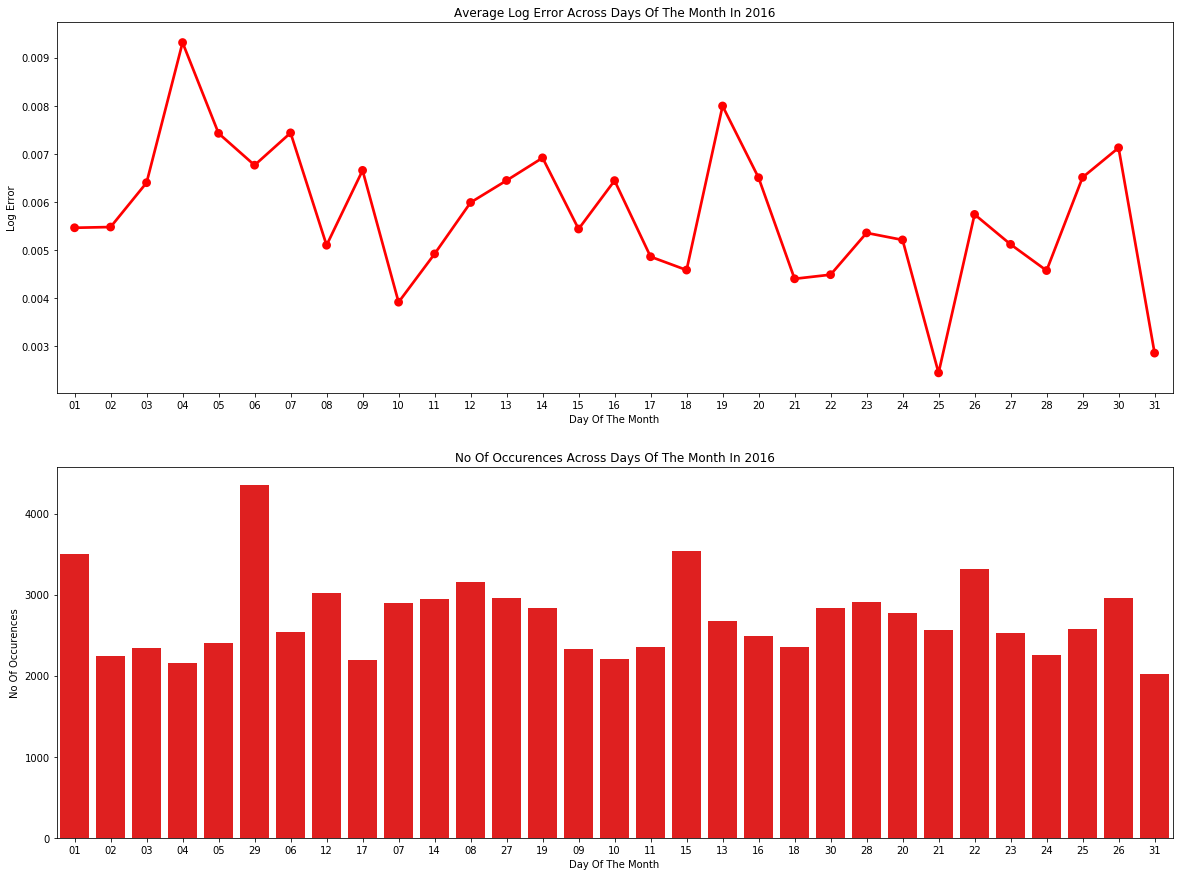

In [21]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,15)

sns.pointplot(x=traingroupedDay["day"], y=traingroupedDay["logerror"], data=traingroupedDay, join=True,ax=ax1,color="red")
ax1.set(xlabel='Day Of The Month', ylabel='Log Error',title="Average Log Error Across Days Of The Month In 2016",label='big')

sns.countplot(x=train_df["day"], data=train_df,ax=ax2,color="red")
ax2.set(xlabel='Day Of The Month', ylabel='No Of Occurences',title="No Of Occurences Across Days Of The Month In 2016",label='big')

In [22]:
important_features(train_df, "logerror",10)

['finishedsquarefeet12',
 'calculatedfinishedsquarefeet',
 'calculatedbathnbr',
 'bathroomcnt',
 'yardbuildingsqft26',
 'finishedsquarefeet6',
 'fullbathcnt',
 'numberofstories',
 'basementsqft',
 'structuretaxvaluedollarcnt']

### finishedsquarefeet12 vs logerror

<Figure size 576x576 with 0 Axes>

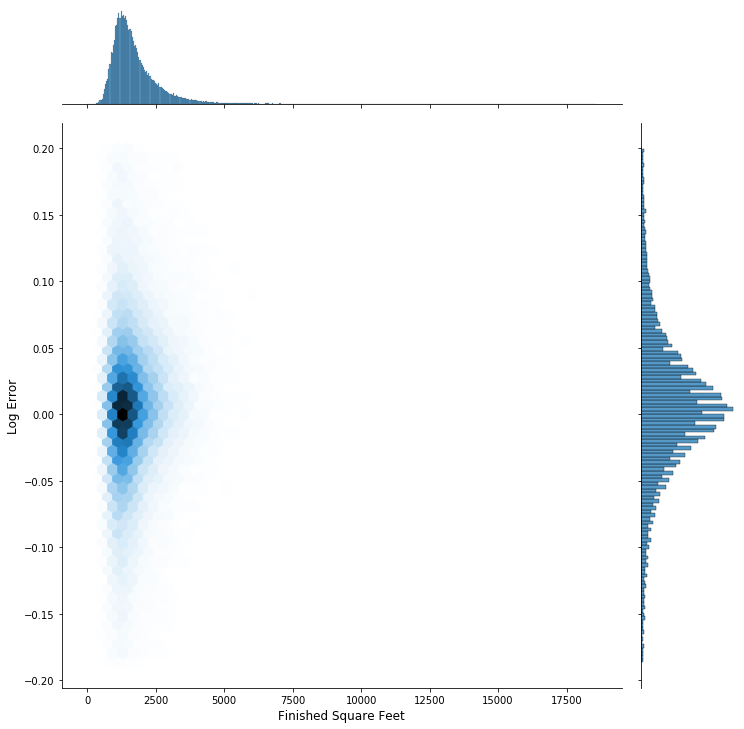

In [23]:
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values, size=10,kind="hex")
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet', fontsize=12)
plt.show()

### calculatedfinishedsquarefeet vs logerror

<Figure size 576x576 with 0 Axes>

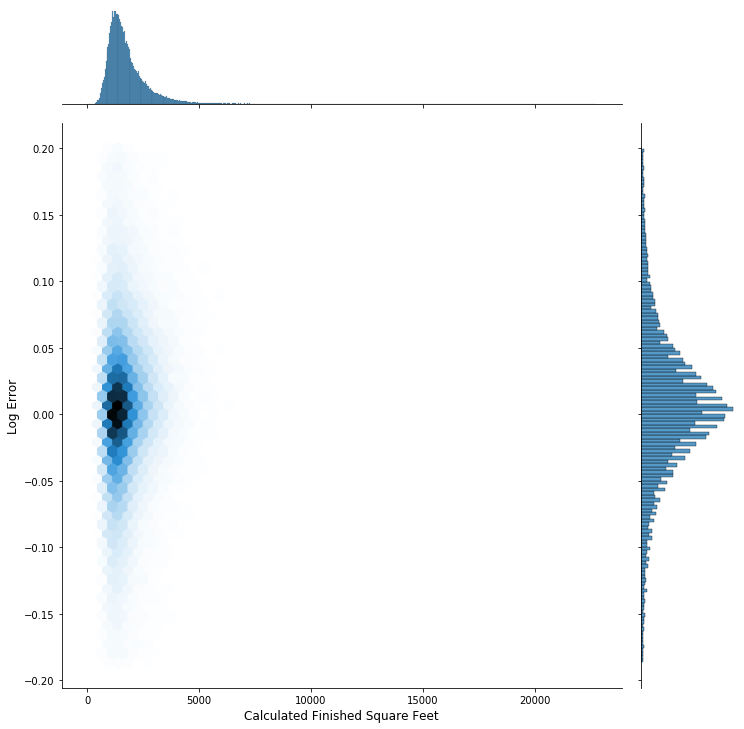

In [24]:
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values, size=10,kind="hex")
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated Finished Square Feet', fontsize=12)
plt.show()

### Bedroom count vs logerror

[Text(0, 0.5, 'Log Error'),
 Text(0.5, 0, 'Bedroom Count'),
 Text(0.5, 1.0, 'Bedroom Count Vs Log Error')]

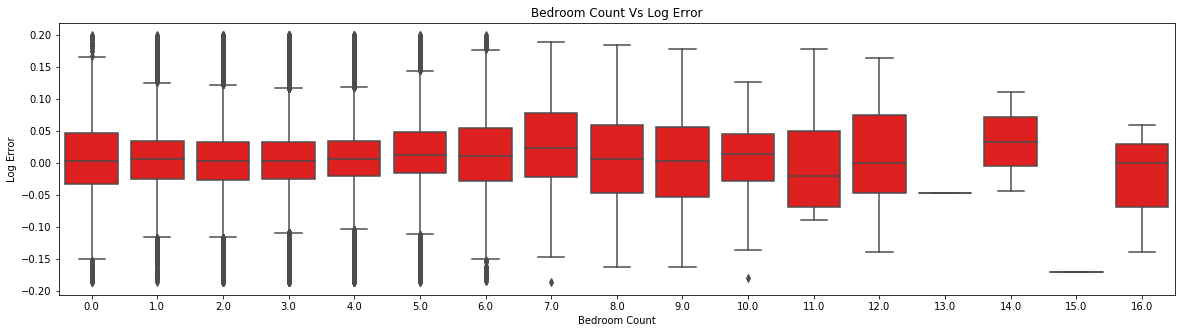

In [25]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sns.boxplot(x="bedroomcnt", y="logerror", data=train_df,ax=ax, color = "red")
ax.set(ylabel='Log Error',xlabel="Bedroom Count",title="Bedroom Count Vs Log Error")

### Bathroom count vs logerror

[Text(0, 0.5, 'Log Error'),
 Text(0.5, 0, 'Bathroom Count'),
 Text(0.5, 1.0, 'Bathroom Count Vs Log Error')]

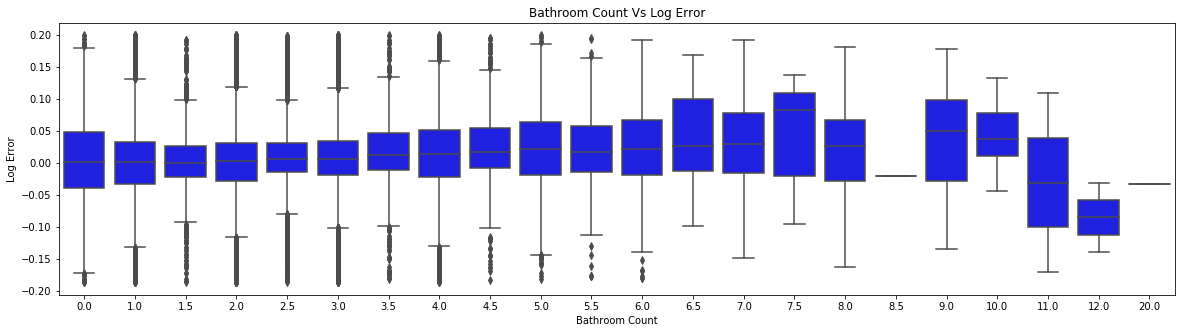

In [26]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df,ax=ax,color="blue")
ax.set(ylabel='Log Error',xlabel="Bathroom Count",title="Bathroom Count Vs Log Error")

### Number Of Stories Vs Log Error

[Text(0, 0.5, 'Log Error'),
 Text(0.5, 0, 'No Of Storeys'),
 Text(0.5, 1.0, 'No Of Storeys Vs Log Error')]

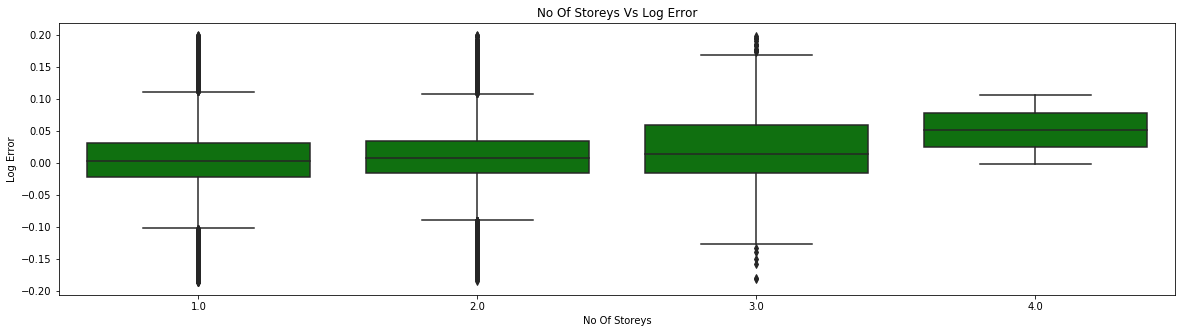

In [27]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sns.boxplot(x="numberofstories", y="logerror", data=train_df,ax=ax,color="green")
ax.set(ylabel='Log Error',xlabel="No Of Storeys",title="No Of Storeys Vs Log Error")

### Room count vs logerror

[Text(0, 0.5, 'Log Error'),
 Text(0.5, 0, 'Room Count'),
 Text(0.5, 1.0, 'Room Count Vs Log Error')]

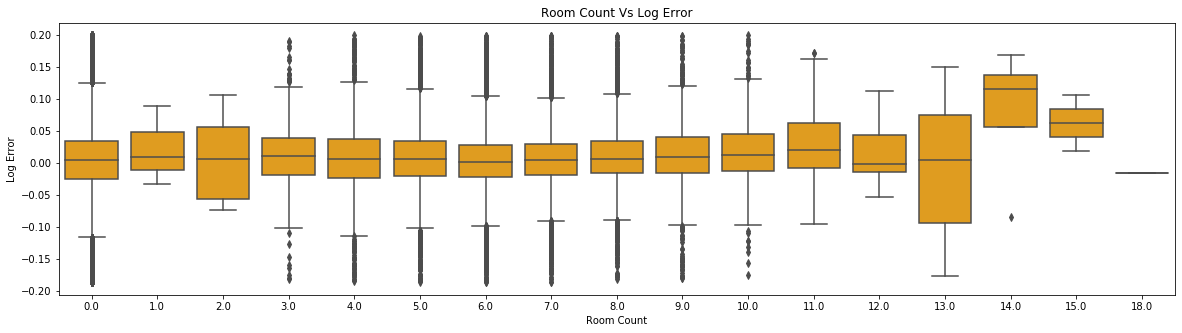

In [28]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sns.boxplot(x="roomcnt", y="logerror", data=train_df,ax=ax,color="orange")
ax.set(ylabel='Log Error',xlabel="Room Count",title="Room Count Vs Log Error")

# Feature Engineering

## Dealing with multi collinearity

As we saw above we have an issue with several features which have high correlation, these include 'calculatedfinishedsquarefeet' 'finishedsquarefeet12' 'finishedsquarefeet13' 'finishedsquarefeet15' 'finishedsquarefeet6, obviously these provide similar information, as 'calculatedfinishedsquarefeet' and 'finishedsquarefeet12' have basically equivalent collinearity with the target we will keep one of the two and remove the rest

In [29]:

dropcols = ['finishedsquarefeet12','finishedsquarefeet13', 'finishedsquarefeet15','finishedsquarefeet6','finishedsquarefeet50','calculatedbathnbr','fullbathcnt']



**bathroomcnt**, **calculatedbathnbr**, **fullbathcnt** have the same info so we will only keep bathroomcnt


# Machine Learning Pipeline

### What Is a Machine Learning Pipeline?

A machine learning pipeline is a way to codify and automate the workflow it takes to produce a machine learning model. Machine learning pipelines consist of multiple sequential steps that do everything from data extraction and preprocessing to model training and deployment.

In [30]:
for c, dtype in zip(property_df.columns, property_df.dtypes):
    if dtype == np.float64:
        property_df[c] = property_df[c].astype(np.float32)

df_train = (train_df.merge(property_df, how='left', on='parcelid')
            .drop(['parcelid', 'transactiondate'], axis=1))

train_columns = df_train.columns 

## Data Split

In [31]:
test = df_train.iloc[1:20000, :]
train = df_train.iloc[20001:90275, :]

In [32]:
y_train = train['logerror'].values
y_test= test['logerror'].values


In [33]:

X_train = train.drop('logerror', axis = 1)
X_test = test.drop('logerror', axis = 1)

In [34]:
idVars = [i for e in ['id',  'flag', 'has'] for i in list(train_columns) if e in i] + ['fips', 'hashottuborspa']
countVars = [i for e in ['cnt',  'year', 'nbr', 'number'] for i in list(train_columns) if e in i]
taxVars = [col for col in train_columns if 'tax' in col and 'flag' not in col]


In [35]:
ttlVars = idVars + countVars + taxVars
dropVars = [i for e in ['census',  'tude', 'error'] for i in list(train_columns) if e in i]
contVars = [col for col in train_columns if col not in ttlVars + dropVars]

In [37]:
for c in X_train.dtypes[X_train.dtypes == object].index.values:
    print(c)
    X_train[c] = (X_train[c] == True)
    
for c in X_test.dtypes[X_test.dtypes == object].index.values:
    X_test[c] = (X_test[c] == True)   

hashottuborspa_x
propertycountylandusecode_x
propertyzoningdesc_x
fireplaceflag_x
taxdelinquencyflag_x
year
month
day
hashottuborspa_y
propertycountylandusecode_y
propertyzoningdesc_y
fireplaceflag_y
taxdelinquencyflag_y


## LGBM Pipeline

This pipeline will work as follows
1. Imputes the missing values with the median
2. Selects the best 10 features
3. Builds a LightGBM model

In [38]:
print(contVars)

x_train_continous = X_train[contVars]
x_test_continous = X_test[contVars]

['transaction_month', 'basementsqft_x', 'finishedfloor1squarefeet_x', 'calculatedfinishedsquarefeet_x', 'finishedsquarefeet12_x', 'finishedsquarefeet13_x', 'finishedsquarefeet15_x', 'finishedsquarefeet50_x', 'finishedsquarefeet6_x', 'fips_x', 'garagetotalsqft_x', 'lotsizesquarefeet_x', 'poolsizesum_x', 'propertycountylandusecode_x', 'propertyzoningdesc_x', 'yardbuildingsqft17_x', 'yardbuildingsqft26_x', 'month', 'day', 'basementsqft_y', 'finishedfloor1squarefeet_y', 'calculatedfinishedsquarefeet_y', 'finishedsquarefeet12_y', 'finishedsquarefeet13_y', 'finishedsquarefeet15_y', 'finishedsquarefeet50_y', 'finishedsquarefeet6_y', 'fips_y', 'garagetotalsqft_y', 'lotsizesquarefeet_y', 'poolsizesum_y', 'propertycountylandusecode_y', 'propertyzoningdesc_y', 'yardbuildingsqft17_y', 'yardbuildingsqft26_y']


**Imputer:** This function is used to impute missing values in the dataset rather than doing it all manually it automates the process. The function takes a number of arguments.
- **missing_values** — This is the value which has to be replaced in the dataset. This could either be an integer, or NaN. If you don’t pass this value, NaN will be the default value. So wherever we have NaN in our dataset, the Imputer object will replace it with a new value.


- **strategy** — This is the strategy we’ll be using to calculate the value which has to replace the NaN occurrences in the dataset. There are three different strategies we can use:
    1. mean (default)
    2. median
    3. most_frequent


- **axis** — This can take one of two values — 0 and 1. This will decide if the Imputer will apply the strategy along the rows or along the columns. 0 for columns, and 1 for rows.


- **verbose** — This will just decide the verbosity of the Imputer. By default, it’s set to 0.


- **copy** — This will decide if a copy of the original object has to be made, or if the Imputer should change the dataset in-place. By default, it is set to True.

In [41]:
pipeline = Pipeline(
                    [('imp', Imputer(missing_values='NaN', strategy = 'median', axis=0)),
                     ('feat_select', SelectKBest(k = 10)),
                     ('lgbm', LGBMRegressor())
                     
])

pipeline.fit(x_train_continous, y_train)   

y_pred = pipeline.predict(x_test_continous)
print('MAE on test set: %s' % (round(MAE(y_test, y_pred), 10)))

MAE on test set: 0.0433234775


# Pipeline with GridSearch Implementation
Gridsearch is used to validate our assumptions about imputation or show that they were incorrect

In [42]:
import sklearn

In [43]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [47]:
pipeline = Pipeline(
                    [('imp', Imputer(missing_values='NaN', axis=0)),
                     ('feat_select', SelectKBest()),
                     ('lgbm', LGBMRegressor())
                     
])

parameters = {}
parameters['imp__strategy'] = ['mean', 'median', 'most_frequent']
parameters['feat_select__k'] = [3,5,10,12,15]

CV = GridSearchCV(pipeline, parameters, scoring = 'neg_mean_squared_error', n_jobs= 1)
CV.fit(x_train_continous, y_train)   

print('Best score and parameter combination = ')

print(CV.best_score_)    
print(CV.best_params_)    

y_pred = CV.predict(x_test_continous)
print('MAE on test set: %s' % (round(MAE(y_test, y_pred), 5)))

Best score and parameter combination = 
-0.0033371610440046454
{'feat_select__k': 15, 'imp__strategy': 'most_frequent'}
MAE on test set: 0.0435


**BaseEstimator** provides among other things a default implementation for the get_params and set_params methods. This is useful to make the model grid search-able with GridSearchCV for automated parameters tuning and behave well with others when combined in a Pipeline



In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, subset):
        self.subset = subset

    def transform(self, X, *_):
        return X.loc[:, self.subset]

    def fit(self, *_):
        return self
ColumnExtractor(taxVars)

ColumnExtractor(subset=['structuretaxvaluedollarcnt_x', 'taxvaluedollarcnt_x',
                        'landtaxvaluedollarcnt_x', 'taxamount_x',
                        'taxdelinquencyyear_x', 'structuretaxvaluedollarcnt_y',
                        'taxvaluedollarcnt_y', 'landtaxvaluedollarcnt_y',
                        'taxamount_y', 'taxdelinquencyyear_y'])

# Final Pipeline

In [52]:
pipeline = Pipeline([
        
    ('union', FeatureUnion(
        transformer_list=[

            ('contVar', Pipeline([
                ('selector', ColumnExtractor(contVars)),
                ('cont_imp', Imputer(missing_values='NaN', strategy = 'median', axis=0)),
                ('scaler', StandardScaler())             
            ])),
            ('taxVar', Pipeline([
                ('selector', ColumnExtractor(taxVars)),
                ('tax_imp', Imputer(missing_values='NaN', strategy = 'most_frequent', axis=0)),
                ('scaler', MinMaxScaler(copy=True, feature_range=(0, 3)))
            ])),
        ],
    )),
    ('feat_select', SelectKBest(k = 5)),    
    ('lgbm', LGBMRegressor()),
])

parameters = {}
parameters['feat_select__k'] = [5, 10,15]

grid = GridSearchCV(pipeline, parameters, scoring = 'neg_mean_absolute_error', n_jobs= 2)
grid.fit(X_train, y_train)   

print('Best score and parameter combination = ')

print(grid.best_score_)    
print(grid.best_params_)    

y_pred = grid.predict(X_test)
print('MAE on test set: %s' % (round(MAE(y_test, y_pred), 5)))

Best score and parameter combination = 
-0.0417531481889816
{'feat_select__k': 15}
MAE on test set: 0.0431
